In [1]:
# import computationally expensive model from file (computed in cell above)
from scipy.sparse import *
import numpy as np
import pickle
import random
xs = pickle.load(open('scratch/embeddings.pkl', 'rb'))
vocab = pickle.load(open('scratch/vocab.pkl', 'rb'))
vocab_inv = {vocab[w]:w for w in vocab}

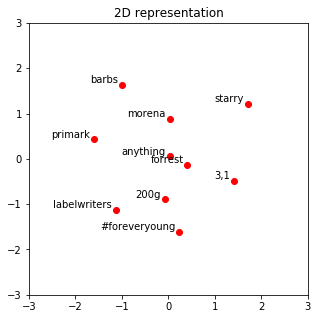

In [2]:
# TEST: Display 20 random words in a 2D PCA representation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
%matplotlib inline

pca = True
words = None

if not words:
    n = 10
    wordindices = np.random.randint(0, xs.shape[0], size = n)
    vectors = [xs[i] for i in wordindices]
    words = [vocab_inv[i] for i in wordindices]
else:
    words = [w for w in words if w in vocab]
    n = len(words)
    wordindices = [vocab[w] for w in words]
    vectors = [xs[i] for i in wordindices]

pca = PCA(n_components=2, whiten=True)
vectors2d = pca.fit(vectors).transform(vectors)
# with t-SNE:
#tsne = TSNE(n_components=2, random_state=0)
#vectors2d = tsne.fit_transform(vectors)

plt.figure(figsize=(5,5))
plt.axis([-3, 3, -3, 3])
    
for point, word in zip(vectors2d , words):
    # plot points
    plt.scatter(point[0], point[1], c='r')
    # plot word annotations
    plt.annotate(word, xy = (point[0], point[1]), xytext = (-4, -0),
                 textcoords = 'offset points', ha = 'right', va = 'bottom')
plt.title('2D representation')
plt.show()

In [6]:
# TEST: find similar word from randomly picked one
from scipy import spatial
from operator import itemgetter

start_word = 'awesome'
if not start_word or (start_word not in vocab):
    # if no start word is chosen, eg. start_word = None, pick one at random
    start_word = vocab_inv[np.random.randint(0, xs.shape[0])]
    print('starting from random word:', start_word)
else:
    print('starting from word:', start_word)

start_ind = vocab.get(start_word)
start_vec = xs[start_ind]

# calculate distance to every other word and print out the nearest 10:
distances = [(i, spatial.distance.cosine(start_vec, xs[i])) for i in range(xs.shape[0])]
distances_sorted = sorted(distances,key=itemgetter(1))
print('Order Distance Word')
print('-------------------')
for k in range(10):
    print('{:<6d}{:<9.5f}{:s}'.format(k, distances_sorted[k][1], vocab_inv[distances_sorted[k][0]]))

starting from word: awesome
Order Distance Word
-------------------
0     -0.00000 awesome
1     0.00097  didn't
2     0.00100  i'll
3     0.00101  watching
4     0.00118  again
5     0.00119  hahaha
6     0.00119  bad
7     0.00119  everyone
8     0.00120  what
9     0.00121  play


In [11]:
# build feature vectors for every tweed in the full corpus set
training_tweeds = []

print('Assigning feature vector to tweeds for training...')
counter = 1
for label, fn in zip([1, -1], ['datasets/train_pos_full.txt', 'datasets/train_neg_full.txt']):
    with open(fn) as f:
        for line in f:
            tokens = [vocab.get(t, -1) for t in line.strip().split()]
            tokens = [t for t in tokens if t >= 0]
            if not tokens:
                print("  couldn't assign tweed '{}' a feature.".format(line[:-2]))
                continue
            vectors = np.array([xs[t] for t in tokens])
            avg_vector = np.average(vectors, axis=0)
            training_tweeds.append((label,avg_vector))
            
            if counter % 50000 == 0:
                print("processed {} tweeds (working on set '{}')".format(counter, fn))
            counter += 1
print("Finished processing {} tweeds.".format(counter, fn))

Assigning feature vector to tweeds for training...
  couldn't assign tweed 'heyheyheyhe' a feature.
processed 50000 tweeds (working on set 'datasets/train_pos_full.txt')
  couldn't assign tweed 'gilipollas #everywher' a feature.
  couldn't assign tweed '#absolutely beastingi' a feature.
processed 100000 tweeds (working on set 'datasets/train_pos_full.txt')
  couldn't assign tweed '#sobersall' a feature.
processed 150000 tweeds (working on set 'datasets/train_pos_full.txt')
  couldn't assign tweed '#thankfuckitsfriday whooos' a feature.
processed 200000 tweeds (working on set 'datasets/train_pos_full.txt')
  couldn't assign tweed '#somethingboutatruck' a feature.
  couldn't assign tweed '#somethingmomsneversa' a feature.
  couldn't assign tweed '#niallwithkoal' a feature.
  couldn't assign tweed '#awebobrothe' a feature.
processed 250000 tweeds (working on set 'datasets/train_pos_full.txt')
  couldn't assign tweed '#twitterduringthedarkcuz_twitterafterdark_istechnicallymornin' a feature

UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 7072: character maps to <undefined>

In [ ]:
# train a linear classifier with support vector machine
from sklearn import svm
# to separate labels and feature vectors of the training data, just unzip the tweed list
Y, X = zip(*training_tweeds)
clf = svm.LinearSVC(verbose=10)
clf.fit(X,Y)


In [10]:
# now classify the vectors in the test data
import csv
import datetime
test_tweeds = []

undeterminable = {4590:1}

with open('datasets/test_data.txt') as f:
    for line in f:
        id, tweed = line.split(',', 1)
        id = int(id)
        label = -1
        tokens = [vocab.get(t, -1) for t in tweed.strip().split()]
        tokens = [t for t in tokens if t >= 0]
        if not tokens:
            print(id)
            label = undeterminable[id]
            print("couldn't assign tweed '{}' a feature. Manually: {}".format(tweed.strip(), label))
        else:
            vectors = np.array([xs[t] for t in tokens])
            label = clf.predict(np.average(vectors, axis=0).reshape(1, -1))
        test_tweeds.append([id, label])

# write classifications in csv file
timestamp = datetime.date.today()
np.savetxt('submissions/submission_{}.csv'.format(timestamp), test_tweeds, delimiter=",", fmt='%d', header='Id,Prediction', comments='')

4590
couldn't assign tweed '#thatsjustmethough' a feature. Manually: 1
